In [ ]:
!pip install alpha_vantage

In [ ]:
import tensorflow as tf
import numpy as np
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt


In [ ]:
# Replace YOUR_API_KEY with your Alpha Vantage API key
ts = TimeSeries(key='WO6IIEBNMUTO92UN', output_format='pandas')
data, meta_data = ts.get_daily_adjusted(symbol='IBM', outputsize='full')


In [ ]:
# Extract the 'Adj Close' column from the data
data = data['4. close'].values.reshape(-1, 1)


In [ ]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)


In [ ]:
# Create input data and labels
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i+look_back, 0])
    return np.array(X), np.array(Y)

look_back = 7 # Number of previous days to use as input features
X, Y = create_dataset(data, look_back)


In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size,:], X[train_size:len(X),:]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]


In [ ]:
# Reshape the input data to be 3-dimensional
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


In [ ]:
# Create the LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')


In [ ]:
# Train the model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY))


Epoch 1/50
147/147 [==============================] - 8s 17ms/step - loss: 0.0843 - val_loss: 0.0229
Epoch 2/50
147/147 [==============================] - 2s 11ms/step - loss: 0.0415 - val_loss: 0.0197
Epoch 3/50
147/147 [==============================] - 2s 11ms/step - loss: 0.0386 - val_loss: 0.0234
Epoch 4/50
147/147 [==============================] - 1s 10ms/step - loss: 0.0360 - val_loss: 0.0195
Epoch 5/50
147/147 [==============================] - 1s 10ms/step - loss: 0.0360 - val_loss: 0.0203
Epoch 6/50
147/147 [==============================] - 1s 10ms/step - loss: 0.0334 - val_loss: 0.0207
Epoch 7/50
147/147 [==============================] - 1s 10ms/step - loss: 0.0326 - val_loss: 0.0232
Epoch 8/50
147/147 [==============================] - 2s 11ms/step - loss: 0.0326 - val_loss: 0.0187
Epoch 9/50
147/147 [==============================] - 2s 11ms/step - loss: 0.0304 - val_loss: 0.0215
Epoch 10/50
147/147 [==============================] - 1s 10ms/step - loss: 0.0306 - val_lo

In [ ]:
testX[0]

array([[0.1946743 ],
       [0.18807939],
       [0.18173334],
       [0.18011572],
       [0.1808001 ],
       [0.18776831],
       [0.18590182]])

In [ ]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

37/37 [==============================] - 1s 3ms/step


In [ ]:
testPredict[0]

array([85.53604], dtype=float32)

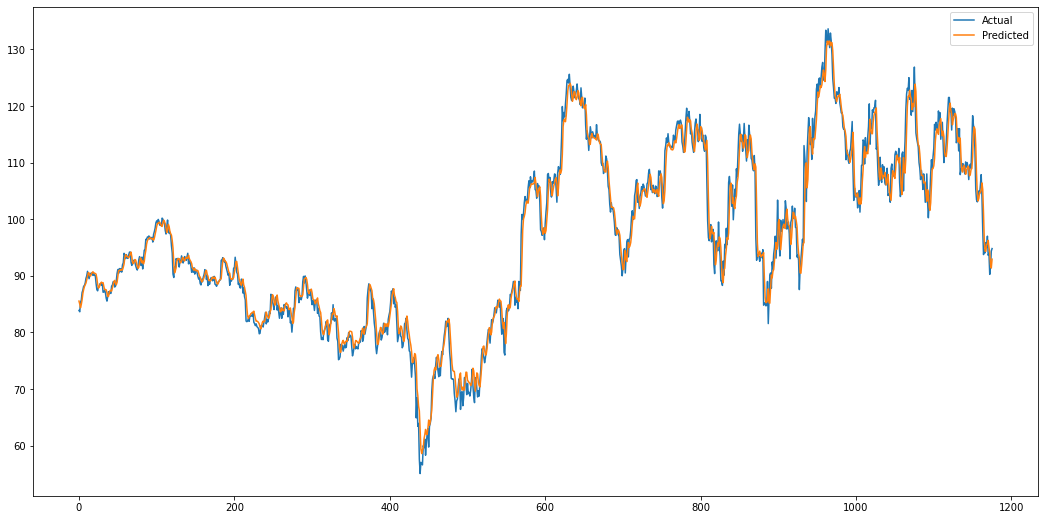

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(testY[0], label='Actual')
plt.plot(testPredict[:,0], label='Predicted')
plt.legend()
plt.show()

In [ ]:
model.save('model.h5')